In [5]:
# Not sure if my environment is weird, but this is necessary for mine.
# import sys
# sys.path.append('./env/lib/python3.6/site-packages')

import overpy

from collections import defaultdict
from copy import deepcopy as copy

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

Grabbing the relevant path data for our area of interest from Open Street Maps.

In [6]:
api = overpy.Overpass()

# Grab all "highways" for SF. According to OpenStreetMap, any traversable path,
# e.g. pedestrian walkways, are highwaysm, so we remove those below.
query_result = api.query("""
    way(37.7085,-122.5145,37.8092,-122.3716) ["highway"];
    (._;>;);
    out body;
    """)



In [7]:
new_results = []
found_types = set()
skipped_types = set()
for way in query_result.ways:
    # Adding `residential` adds a bunch of smaller streets, which is more accurate, but also
    # makes the visualization a fair bit less recognizable.
    if way.tags.get('highway', 'n/a') in ['motorway', 'trunk', 'primary', 'secondary', 'tertiary', 
                                           'motorway_link', 'trunk_link', 'primary_link', 'secondary_link',
                                           'tertiary_link', 'living_street']: #, 'residential']:
        new_results.append(way)
        found_types.add(way.tags.get('highway', 'n/a'))
    else:
        skipped_types.add(way.tags.get('highway', 'n/a'))

Display the full map highlighting intersections

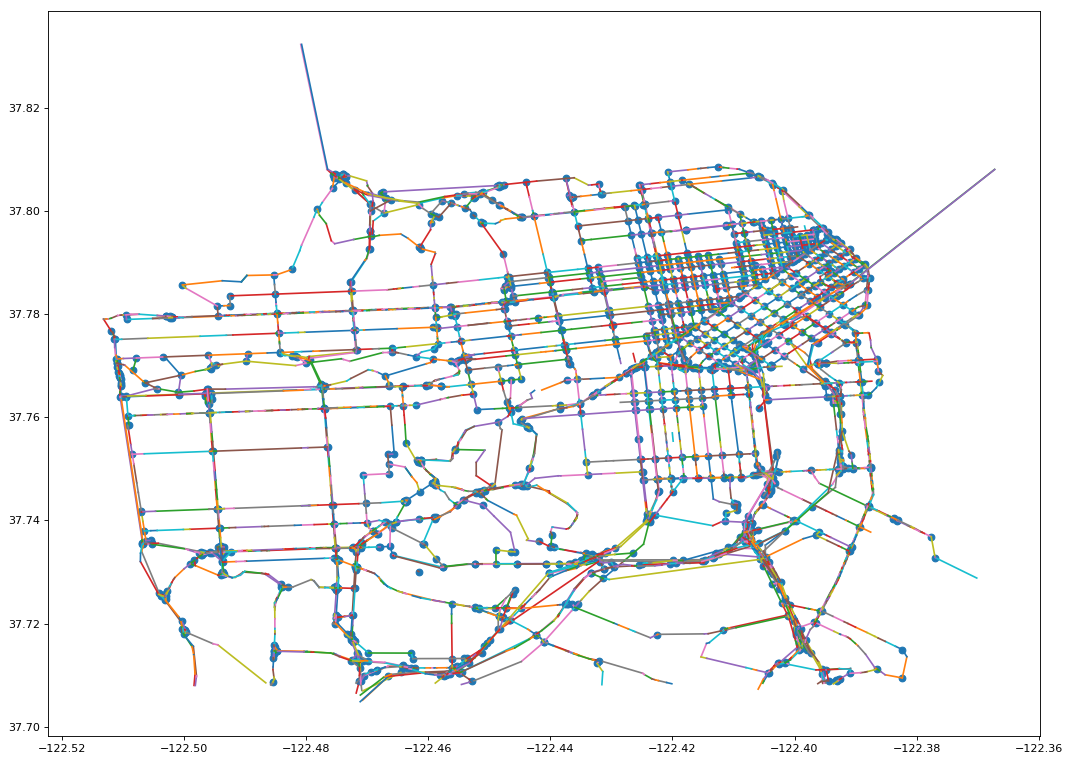

In [9]:
# Create a mapping of points to the roads that lay on them.
point_to_road = defaultdict(set)

for result in new_results:
    name = result.tags.get("name", "n/a")
    for node in result.nodes:
        point_to_road[(node.lon, node.lat)].add(name)

# Now loop through the list of all points to find those that are actually intersections.
intersections = set()
for (lon, lat), name_set in point_to_road.items():
    # It's only an intersection if at least 2 streets intersect there.
    # Technically we may miss streets that curve and intersect with themselves,
    # but that's fine.
    if len(name_set) > 1:
        intersections.add((lon, lat))
        
# For this visualization, let's also map all the roads (with slightly less granularity)
# to sanity-check that intersections look right.
routes_lon = []
routes_lat = []

for result in new_results:
    routes_lon.append([result.nodes[0].lon, result.nodes[-1].lon])
    routes_lat.append([result.nodes[0].lat, result.nodes[-1].lat])


    
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(*zip(*intersections))
for route_i in range(len(routes_lon)):
    plt.plot(routes_lon[route_i], routes_lat[route_i])
plt.show()

Generate a list of vertices/coordinates and the edges between them. The map above draws the edges, but they're not really connected. The below can be used to initialize our driving environment.

In [10]:
# As before, create a mapping of points to the roads that lay on them.
point_to_road = defaultdict(set)
# Also keep track of all paths (which may represent just a small part of a road)
paths = []

for result in new_results:
    name = result.tags.get("name", "n/a")
    for node in result.nodes:
        point_to_road[(node.lon, node.lat)].add(name)
    paths.append(((result.nodes[0].lon, result.nodes[0].lat),(result.nodes[-1].lon, result.nodes[-1].lat)))

# As before, find the intersections
intersections = set()

for (lon, lat), name_set in point_to_road.items():
    if len(name_set) > 1:
        intersections.add((lon, lat))

# Find between which intersections there exists a continuous path. Store these as
# pairs of ((lon_1, lat_1), (lon_2, lat_2))
intersection_paths = set()
# TODO: This is pretty inefficient right now, but it also seems to run quickly enough
# and works. Would be nice to make more efficient if necessary in the future, though.
for start_point in intersections:
    # Keep track of all reachable points from this one that do not require passing
    # through another intersection.
    reachable_points = set()
    # Do an n**2 looping where n is the number of mini-edges from the original datasource.
    # This outerloop is like the time step.
    for _ in range(len(paths)):
        # We can often break early, which is detectable when no new reachable points
        # were found.
        prev_reachable_points = copy(reachable_points)
        for path_start, path_end in paths:
            # If one end of the path has been found as reachable, add the other end
            # as also reachable. But, be careful not to go through other intersections,
            # as we only care about the 1-step reachable intersections.
            if path_start in reachable_points and path_start not in intersections:
                reachable_points.add(path_end)
            if path_end in reachable_points and path_end not in intersections:
                reachable_points.add(path_start)
            # To get things started, mark points as reachable if one end of the path
            # is the starting point of this intersection
            if start_point == path_start:
                reachable_points.add(path_end)
            if start_point == path_end:
                reachable_points.add(path_start)
        # Break if we won't be doing any more updates on this intersection
        if prev_reachable_points == reachable_points:
            break
    for point in reachable_points:
        if point in intersections:
            # We actually find each edge twice (once from each direction), so 
            # a quick check to avoid double-adding
            if (point, start_point) in intersection_paths:
                continue
            intersection_paths.add((start_point, point))

3743


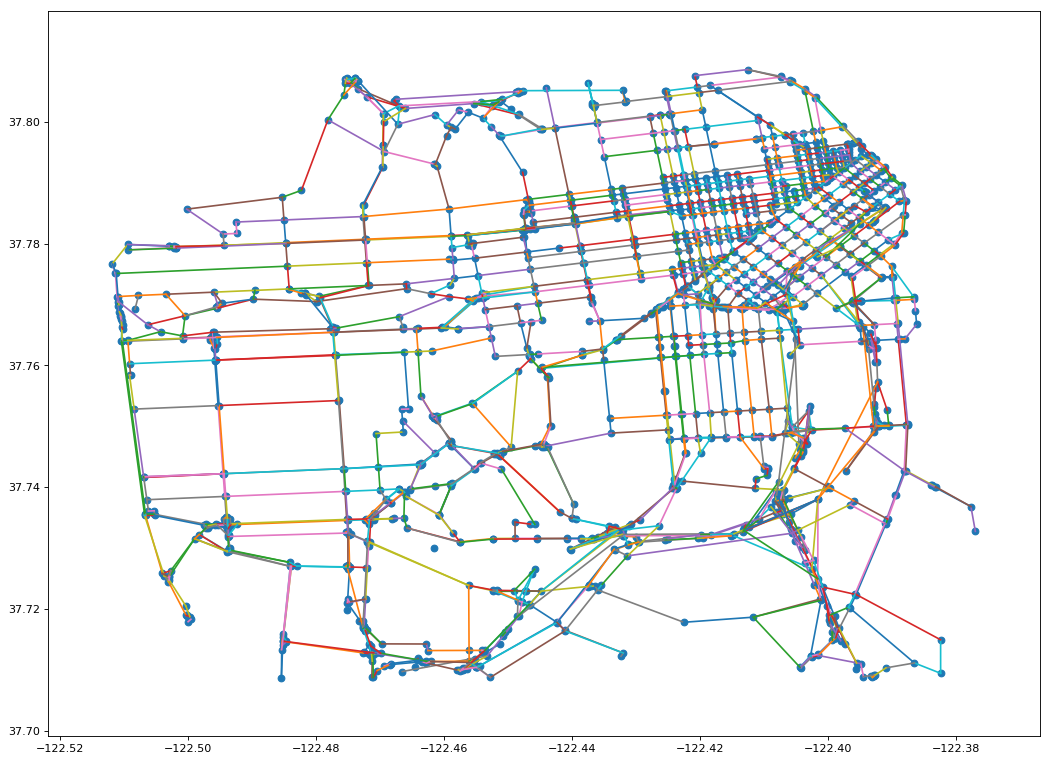

In [11]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')

print(len(intersection_paths))

plt.scatter(*zip(*intersections))
for path in intersection_paths:
    plt.plot(*zip(*path))

plt.show()

In [ ]:
# TODO: Probably add some export so we can easily load this in and use it to construct
# a graph for our experiments.